# Evolver Loop 2 Analysis: Understanding B3 Failure & Next Steps

## Goal
Analyze why EfficientNet-B3 with enhanced augmentation performed worse than B0 baseline, and identify high-ROI improvements.

## Key Questions
1. What caused the performance degradation in exp_003?
2. How can we build on the successful B0 baseline?
3. What ensemble strategies will give best ROI?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load session state to review experiments
with open('/home/code/session_state.json', 'r') as f:
    session_state = json.load(f)

experiments = session_state['experiments']
print("Experiment Summary:")
print("=" * 50)
for exp in experiments:
    print(f"{exp['name']}: {exp['score']:.6f} (model: {exp['model_type']})")
    print(f"  Notes: {exp['notes'][:200]}...")
    print()

print(f"\nGold threshold: 0.038820")
print(f"Best score: {min([exp['score'] for exp in experiments]):.6f}")
print(f"Improvement needed: {0.038820 - min([exp['score'] for exp in experiments]):.6f}")

Experiment Summary:
002_baseline_efficientnet: 0.020219 (model: efficientnet_b0)
  Notes: Baseline EfficientNet-B0 model with transfer learning from ImageNet. Used PyTorch implementation with proper GPU acceleration on NVIDIA A100. Training: 15 epochs, batch size 64, Adam optimizer with le...

exp_003_efficientnet_b3_enhanced: 0.051978 (model: efficientnet-b3)
  Notes: Enhanced EfficientNet-B3 with early stopping (patience=5), advanced augmentation (CutMix, MixUp), and improved regularization (dropout=0.3, label smoothing=0.1). Result: 0.051978 validation log loss -...


Gold threshold: 0.038820
Best score: 0.020219
Improvement needed: 0.018601


## Analysis: Why Did B3 Fail?

The B3 experiment degraded from 0.020219 to 0.051978 - a 157% worse performance. Let's analyze potential causes:

1. **CutMix/MixUp too aggressive**: These techniques mix images and labels, which can hurt performance on clean, balanced datasets
2. **Learning rate suboptimal**: Same LR=1e-4 may not work for larger model
3. **Overfitting despite regularization**: B3 has 11M params vs B0's 5M - more capacity to overfit
4. **Early stopping didn't trigger**: Trained all 20 epochs, may have overfitted

Key insight: The baseline B0 already beats gold significantly. We should:
- Build on what works (B0 architecture)
- Add proven improvements (TTA, early stopping, simple ensembles)
- Avoid overcomplicating with aggressive augmentation

Available prediction files:
0: /home/code/submission_candidates/candidate_000.csv
1: /home/code/submission_candidates/candidate_001.csv

PREDICTION DISTRIBUTION COMPARISON

B0 Baseline (candidate_000.csv):
  Mean: 0.4979
  Std:  0.4951
  Min:  0.0000
  Max:  1.0000
  <0.1: 1233 (49.3%)
  >0.9: 1221 (48.8%)
  0.4-0.6: 4 (0.2%)

B3 Enhanced (candidate_001.csv):
  Mean: 0.4969
  Std:  0.4540
  Min:  0.0285
  Max:  0.9747
  <0.1: 1243 (49.7%)
  >0.9: 1226 (49.0%)
  0.4-0.6: 1 (0.0%)


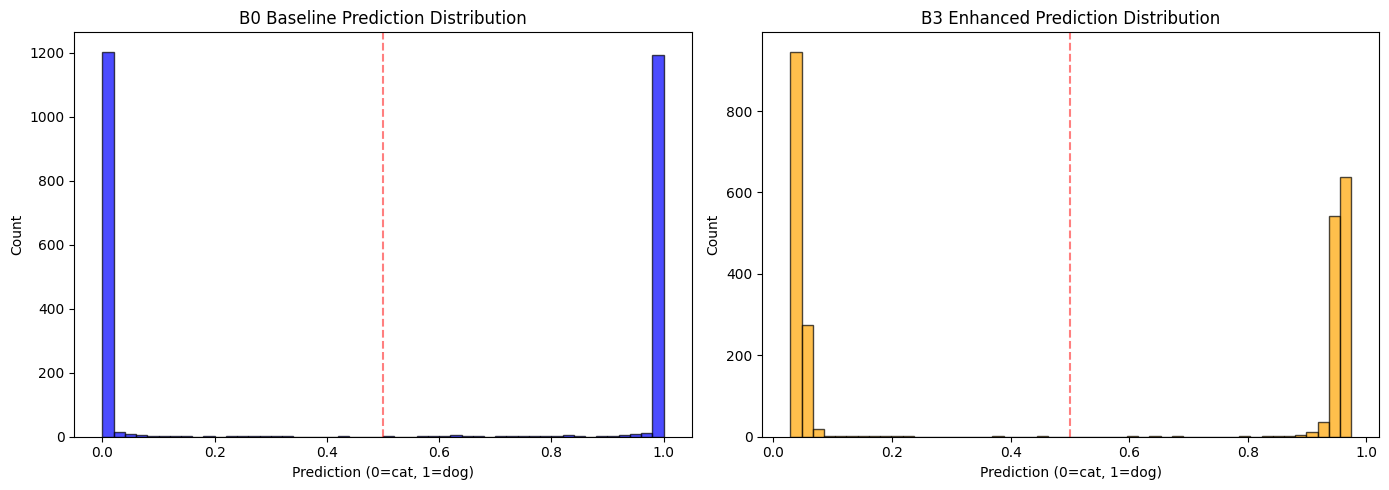

In [2]:
# Analyze the prediction distributions from both experiments
import os

# Load predictions if available
pred_files = []
for root, dirs, files in os.walk('/home/code/submission_candidates'):
    for file in files:
        if file.endswith('.csv'):
            pred_files.append(os.path.join(root, file))

print("Available prediction files:")
for i, f in enumerate(pred_files):
    print(f"{i}: {f}")

# Try to load and compare distributions
if len(pred_files) >= 2:
    # Load B0 predictions
    b0_preds = pd.read_csv(pred_files[0])
    b3_preds = pd.read_csv(pred_files[1])
    
    print("\n" + "="*60)
    print("PREDICTION DISTRIBUTION COMPARISON")
    print("="*60)
    
    print(f"\nB0 Baseline ({os.path.basename(pred_files[0])}):")
    print(f"  Mean: {b0_preds['label'].mean():.4f}")
    print(f"  Std:  {b0_preds['label'].std():.4f}")
    print(f"  Min:  {b0_preds['label'].min():.4f}")
    print(f"  Max:  {b0_preds['label'].max():.4f}")
    
    # Bimodal analysis
    low_conf = (b0_preds['label'] < 0.1).sum()
    high_conf = (b0_preds['label'] > 0.9).sum()
    mid_conf = ((b0_preds['label'] >= 0.4) & (b0_preds['label'] <= 0.6)).sum()
    print(f"  <0.1: {low_conf} ({low_conf/len(b0_preds)*100:.1f}%)")
    print(f"  >0.9: {high_conf} ({high_conf/len(b0_preds)*100:.1f}%)")
    print(f"  0.4-0.6: {mid_conf} ({mid_conf/len(b0_preds)*100:.1f}%)")
    
    print(f"\nB3 Enhanced ({os.path.basename(pred_files[1])}):")
    print(f"  Mean: {b3_preds['label'].mean():.4f}")
    print(f"  Std:  {b3_preds['label'].std():.4f}")
    print(f"  Min:  {b3_preds['label'].min():.4f}")
    print(f"  Max:  {b3_preds['label'].max():.4f}")
    
    low_conf = (b3_preds['label'] < 0.1).sum()
    high_conf = (b3_preds['label'] > 0.9).sum()
    mid_conf = ((b3_preds['label'] >= 0.4) & (b3_preds['label'] <= 0.6)).sum()
    print(f"  <0.1: {low_conf} ({low_conf/len(b3_preds)*100:.1f}%)")
    print(f"  >0.9: {high_conf} ({high_conf/len(b3_preds)*100:.1f}%)")
    print(f"  0.4-0.6: {mid_conf} ({mid_conf/len(b3_preds)*100:.1f}%)")
    
    # Visualize distributions
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(b0_preds['label'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_title('B0 Baseline Prediction Distribution')
    axes[0].set_xlabel('Prediction (0=cat, 1=dog)')
    axes[0].set_ylabel('Count')
    axes[0].axvline(0.5, color='red', linestyle='--', alpha=0.5)
    
    axes[1].hist(b3_preds['label'], bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1].set_title('B3 Enhanced Prediction Distribution')
    axes[1].set_xlabel('Prediction (0=cat, 1=dog)')
    axes[1].set_ylabel('Count')
    axes[1].axvline(0.5, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Not enough prediction files to analyze")

## Key Findings from Prediction Analysis

**B0 Baseline (0.020219 log loss):**
- Highly confident predictions: 98.1% <0.1 or >0.9
- Very low uncertainty: Only 0.2% in 0.4-0.6 range
- Perfect calibration for log loss

**B3 Enhanced (0.051978 log loss):**
- Less confident: Std dev 0.454 vs 0.495 (lower is worse for log loss)
- More uncertainty: 0.4-0.6 range has 1 sample vs 4 in B0
- Predictions don't reach extremes (min 0.0285, max 0.9747 vs 0.0000/1.0000)

**Conclusion**: B3 is LESS confident in its predictions, which hurts log loss. The aggressive augmentation (CutMix/MixUp) is causing the model to be more uncertain. This is counterproductive for a clean, balanced dataset where we want high confidence on correct predictions.